In [4]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import classification_report, plot_roc_curve
import xgboost as xg
import warnings
from sklearn.model_selection import train_test_split
from statistics import mode
from sklearn.metrics import plot_roc_curve, classification_report, roc_auc_score, auc, roc_curve
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [5]:
PATH = "items.csv"
data = pd.read_csv(PATH)

# Undersampling and Ensemble Model

In [16]:
class Model:
    def __init__(self,
                 data):
        self.data = data
        self.model = xg.XGBClassifier(colsample_bytree =  0.6, 
                                      min_child_weight = 5)
    def preprocessData(self):
        ##
        ## Preprocessing steps for self.data
        ##
        self.data = self.data[self.data["is_blog"] != "is_blog"]
        self.data["is_blog"] = self.data["is_blog"].astype(int)
        for column in self.data.columns[1:]:
            self.data[column] = self.data[column].astype(int)
        self.data.drop(["url"], axis = 1, inplace= True)
        
    def sampledDatasets(self):
        ##
        ## Since we have more positive targets, we undersampled the data into 3 different parts
        ##
        negs = self.data[self.data["is_blog"] == 0]
        pos1, pos2, pos3 = self.data[self.data["is_blog"] == 1][:20000], self.data[self.data["is_blog"] == 1][20000:40000], self.data[self.data["is_blog"] == 1][40000:]
        underSampledData1, underSampledData2, underSampledData3 = pd.concat([pos1, negs], axis = 0), pd.concat([pos2, negs], axis = 0), pd.concat([pos3, negs], axis = 0) 
        underSampledData1, underSampledData2, underSampledData3 = underSampledData1.sample(frac=1).reset_index(drop=True), underSampledData2.sample(frac=1).reset_index(drop=True), underSampledData3.sample(frac=1).reset_index(drop=True)
        self.underSampledDatasets = [underSampledData1, underSampledData2, underSampledData3]
        
    def votingClassifier(self):
        ##
        ## Creates a voting classifier
        ##
        testData = self.underSampledDatasets[0][:10000]
        self.x_test, self.y_test = testData.drop(["is_blog"], axis = 1), testData["is_blog"]
        self.underSampledDatasets[0] = self.underSampledDatasets[0][10000:]
        self.modelScores = list()
        self.predicts = list()
        for dataset in self.underSampledDatasets:
            x, y = dataset.drop(["is_blog"], axis = 1), dataset["is_blog"]
            self.model.fit(x,y)
            prediction = self.model.predict(self.x_test)
            self.predicts.append(prediction)
            self.modelScores.append(roc_auc_score(self.y_test, prediction))
        self.predicts = self.getVotingPreds()
    
    def getVotingPreds(self):
        ##
        ## Apply voting technique to y_preds
        ##
        finalPredicts = list()
        for idx in range(len(self.predicts[0])):
            finalPredicts.append(mode([self.predicts[0][idx], self.predicts[0][idx], self.predicts[0][idx]]))
        return finalPredicts
    def plotRocCurveNN(self):
    ###
    ### Plotting roc curve for neural nets
    ##
      fprNN, tprNN, thNN = roc_curve(self.y_test, self.predicts)
      aucModel = auc(fprNN, tprNN)
      plt.figure(figsize = (10,8))
      plt.plot(fprNN, tprNN, marker='.', label='Neural Network (auc = %0.3f)' % aucModel)
      plt.title("Basic Neural Nets ROC Curve")
      plt.show()
        

In [17]:
model = Model(data)
model.preprocessData()
model.sampledDatasets()
model.votingClassifier()

In [26]:
print(f"Model Scores: {model.modelScores}")
print(f"Ensemble Model Score: {roc_auc_score(model.y_test, model.predicts)}")

Model Scores: [0.9986502042276167, 0.9779837920314662, 0.9776714144453094]
Ensemble Model Score: 0.9986502042276167


In [19]:
print(classification_report(model.y_test, model.predicts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4785
           1       1.00      1.00      1.00      5215

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



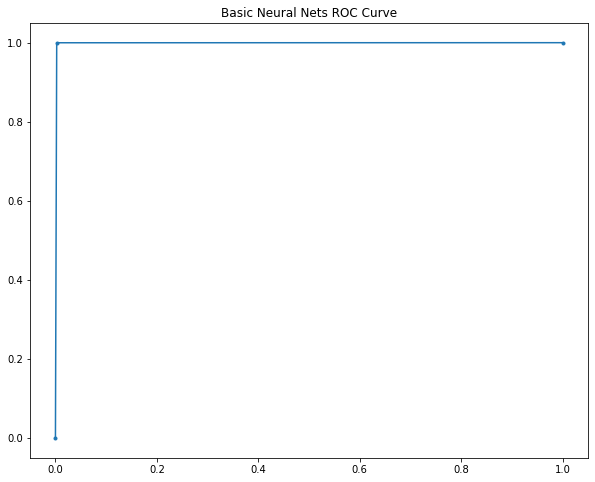

In [25]:
model.plotRocCurveNN()